In [2]:
import random
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import binom
import itertools 
import random
# import intertools

In [12]:
def binomial(n, k, p =0.5):
    return math.comb(n, k)*p**k *(1-p)**(n-k)
def distance(a, b):
    return int(np.sum((a + b) % 2))

In [4]:
# Constants (adjust based on your C code)
SYS_N = 3488  # Example, must match your C code
BYTES_PER_V = SYS_N # Each v is SYS_N bits = SYS_N/8 bytes

# Read binary file
with open("same_sample.bin", "rb") as f:
    data = f.read()
# Convert to numpy array (each row is a 'v' vector)
num_vectors = len(data) // BYTES_PER_V
same_sample = np.frombuffer(data, dtype=np.uint8).reshape((num_vectors, BYTES_PER_V))

# Read binary file
with open("same_instance.bin", "rb") as f:
    data = f.read()
# Convert to numpy array (each row is a 'v' vector)
num_vectors = len(data) // BYTES_PER_V
same_instance = np.frombuffer(data, dtype=np.uint8).reshape((num_vectors, BYTES_PER_V))

# Read binary file
with open("diff_sample.bin", "rb") as f:
    data = f.read()
# Convert to numpy array (each row is a 'v' vector)
num_vectors = len(data) // BYTES_PER_V
diff_sample = np.frombuffer(data, dtype=np.uint8).reshape((num_vectors, BYTES_PER_V))

ValueError: cannot reshape array of size 18080000 into shape (5183,3488)

In [4]:
print(len(same_sample), len(same_instance))


1250 1250


In [5]:
list_combinatiosn = []
while len(list_combinatiosn) < 10000:
    indices = sorted(random.sample(range(len(same_sample)), 2))
    if indices not in list_combinatiosn:
        list_combinatiosn.append(indices)
    print(len(list_combinatiosn), end = '\r')

In [8]:
hamming_distances_same_sample = []
hamming_distances_diff_sample = []
hamming_distances_same_instance = []

for i,j in list_combinatiosn:
    xor_result = np.bitwise_xor(same_sample[i], same_sample[j])
    hamming_distances_same_sample.append(np.unpackbits(xor_result).sum())
    xor_result = np.bitwise_xor(diff_sample[i], diff_sample[j])
    hamming_distances_diff_sample.append(np.unpackbits(xor_result).sum())
    xor_result = np.bitwise_xor(same_instance[i], same_instance[j])
    hamming_distances_same_instance.append(np.unpackbits(xor_result).sum())

In [10]:
bins = np.arange(13500, 14501, 20)
H1, centers1 = np.histogram(hamming_distances_same_sample, density = True, bins = bins)
centers1 = (centers1[1:]+centers1[:-1])/2
H2, centers2 = np.histogram(hamming_distances_same_instance, bins = bins, density = True)
centers2 = (centers2[1:]+centers2[:-1])/2
H3, centers3 = np.histogram(hamming_distances_diff_sample, bins = bins, density = True)
centers3 = (centers3[1:]+centers3[:-1])/2
H4 = binom.pmf(centers2, SYS_N*8, 0.5)

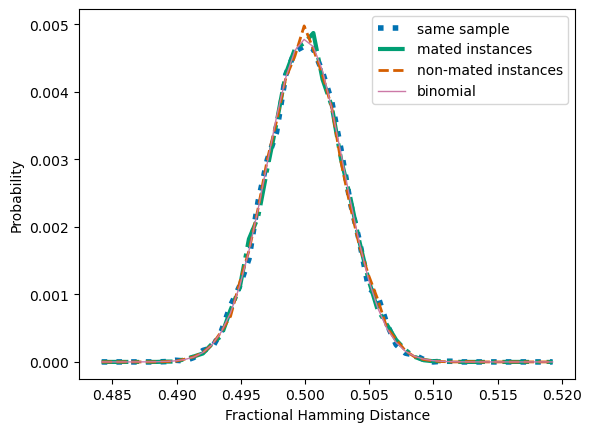

In [13]:
plt.plot(centers1/SYS_N/8, H1*1, label="same sample", linestyle="dotted", color="#0072B2", linewidth= 4)  # Blue
plt.plot(centers2/SYS_N/8, H2*1, label="mated instances", linestyle="-.", color="#009E73", linewidth= 3)  # Green
plt.plot(centers3/SYS_N/8, H3, label="non-mated instances", linestyle="--", color="#D55E00", linewidth= 2)  # Orange
plt.plot(centers2/SYS_N/8, binom.pmf(centers2, 27904, 0.5), label="binomial", color="#CC79A7", linewidth= 1.0)  # Purple
plt.ylabel("Probability")
plt.xlabel("Fractional Hamming Distance")
plt.legend()
plt.savefig("revocability_unlinkability.pdf", bbox_inches='tight')


In [188]:
len(H1)

50

In [194]:
chi2_1 = np.sum( ((H1-binom.pmf(centers2, 27904, 0.5))[binom.pmf(centers2, 27904, 0.5)>0]**2/binom.pmf(centers2, 27904, 0.5)[binom.pmf(centers2, 27904, 0.5)>0]))
chi2_2 = np.sum( ((H2-binom.pmf(centers2, 27904, 0.5))[binom.pmf(centers2, 27904, 0.5)>0]**2/binom.pmf(centers2, 27904, 0.5)[binom.pmf(centers2, 27904, 0.5)>0]))
chi2_3 = np.sum( ((H3-binom.pmf(centers2, 27904, 0.5))[binom.pmf(centers2, 27904, 0.5)>0]**2/binom.pmf(centers2, 27904, 0.5)[binom.pmf(centers2, 27904, 0.5)>0]))

print("d.o.f.", np.sum(binom.pmf(centers2, 27904, 0.5)>0), "chi2", chi2_1, chi2_2, chi2_3)


d.o.f. 50 chi2 0.0002486568322466203 0.00033633729950699866 0.0001871747238994376


In [ ]:
# Calculate chi2 values for curve 1 (H1) compared to H2 and H3
chi2_1_vs_2 = np.sum(((H1 - H2)[H2 > 0] ** 2) / H2[H2 > 0])
chi2_1_vs_3 = np.sum(((H1 - H3)[H3 > 0] ** 2) / H3[H3 > 0])
chi2_1_vs_2 = np.sum(((H1 - H2)[H2 > 0] ** 2) / H2[H2 > 0])
chi2_1_vs_3 = np.sum(((H1 - H3)[H3 > 0] ** 2) / H3[H3 > 0])
print("chi2 (curve 1 vs 2):", chi2_1_vs_2)
print("chi2 (curve 1 vs 3):", chi2_1_vs_3)

chi2 (curve 1 vs 2): 0.0001785037009829555
chi2 (curve 1 vs 3): 0.00039969826053692004


## Similarity based attacks

In [45]:
# Open and read the binary files, converting them into NumPy arrays of 3488 bits (436 bytes) per row
with open("same_sample.bin", "rb") as f:
    data = f.read()
num_vectors = len(data) // int(3488 / 8 * 2 + 32)
same_sample = np.frombuffer(data, dtype=np.uint8).reshape((num_vectors, int(3488 / 8 * 2 + 32)))
same_sample = {
    "w_bio": np.unpackbits(same_sample[:, :int(3488 / 8)], axis=1),
    "v": np.unpackbits(same_sample[:, int(3488 / 8):int(3488 / 8 * 2)], axis=1),
    "id_x": (same_sample[:, int(3488 / 8 * 2):])
}
with open("same_instance.bin", "rb") as f:
    data = f.read()
num_vectors = len(data) // int(3488 / 8 * 2 + 32)
same_instance = np.frombuffer(data, dtype=np.uint8).reshape((num_vectors, int(3488 / 8 * 2 + 32)))
same_instance = {
    "w_bio": np.unpackbits(same_instance[:, :int(3488 / 8)], axis=1),
    "v": np.unpackbits(same_instance[:, int(3488 / 8):int(3488 / 8 * 2)], axis=1),
    "id_x": (same_instance[:, int(3488 / 8 * 2):])

}
with open("diff_sample.bin", "rb") as f:
    data = f.read()
num_vectors = len(data) // int(3488 / 8 * 2 + 32)
diff_sample = np.frombuffer(data, dtype=np.uint8).reshape((num_vectors, int(3488 / 8 * 2 + 32)))
diff_sample = {
    "w_bio": np.unpackbits(diff_sample[:, :int(3488 / 8)], axis=1),
    "v": np.unpackbits(diff_sample[:, int(3488 / 8):int(3488 / 8 * 2)], axis=1),
    "id_x": (diff_sample[:, int(3488 / 8 * 2):])

}

In [ ]:
pairs = [random.sample(range(10000), 2) for _ in range(10000)]
interclass_distances_bio = []
interclass_distances_encr = []
intraclass_distances_bio = []
intraclass_distances_encr = []
for pair in pairs:
    interclass_distances_bio.append(distance(same_instance["w_bio"][pair[0]], same_instance["w_bio"][pair[1]]))
    interclass_distances_encr.append(distance(same_instance["v"][pair[0]], same_instance["v"][pair[1]]))
    intraclass_distances_bio.append(distance(diff_sample["w_bio"][pair[0]], diff_sample["w_bio"][pair[1]]) )
    intraclass_distances_encr.append( distance(diff_sample["v"][pair[0]], diff_sample["v"][pair[1]]))

(array([ 113., 1605., 2737.,  543.,   12.,   67., 1343., 2756.,  794.,
          30.]),
 array([ 64.,  80.,  96., 112., 128., 144., 160., 176., 192., 208., 224.]),
 <BarContainer object of 10 artists>)

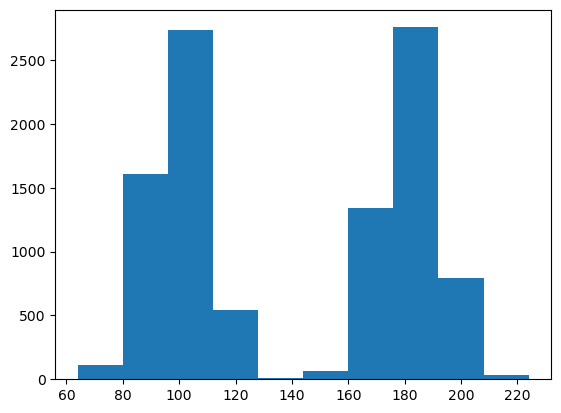

In [44]:
# plt.hist([np.sum(np.sum(diff_sample["w_bio"][pairs[i]], axis = 0)%2) for i in range(2000)])
plt.hist(interclass_distances_bio)

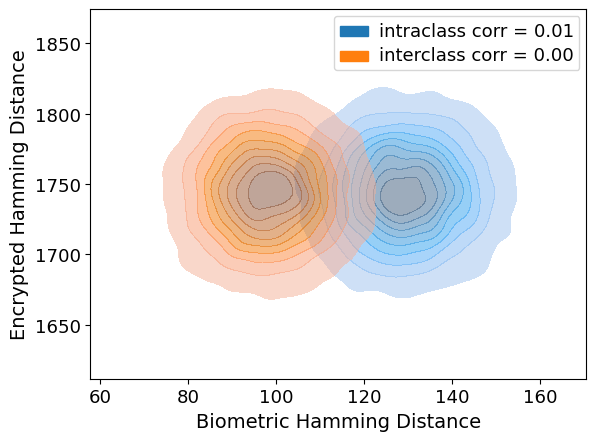

In [78]:
import seaborn as sns
import pandas as pd

# # plt.plot(intraclass_distances_bio[0], intraclass_distances_encr[0], "o", markersize=5, alpha=0.9, label=f"intraclass corr:{np.corrcoef(intraclass_distances_bio, intraclass_distances_encr)[0, 1]:.2f}")
# # plt.plot(interclass_distances_bio[0], interclass_distances_encr[0], "o", markersize=5, alpha=0.9, label=f"interclass corr:{np.corrcoef(interclass_distances_bio, interclass_distances_encr)[0, 1]:.2f}")
# # Plot KDE for intraclass distances
# sns.kdeplot(
#     x=intraclass_distances_bio,
#     y=intraclass_distances_encr,
#     cmap="Blues",
#     fill=True,
#     thresh=0.05,
#     levels=10,
#     alpha=0.5,
#     label="intraclass"
# )
# sns.kdeplot(
#     x=interclass_distances_bio,
#     y=interclass_distances_encr,
#     cmap="Oranges",
#     fill=True,
#     thresh=0.05,
#     levels=10,
#     alpha=0.3,
#     label="intraclass"
# )
plt.xlabel("Biometric Hamming Distance")
plt.ylabel("Encrypted Hamming Distance")
# Create a DataFrame for plotting with hue
df_plot = pd.DataFrame({
    "bio": intraclass_distances_bio + interclass_distances_bio,
    "encr": intraclass_distances_encr + interclass_distances_encr,
    "": ["intraclass corr = 0.01"] * len(intraclass_distances_bio) + ["interclass corr = 0.00"] * len(interclass_distances_bio)
})

ax = sns.kdeplot(
    data=df_plot,
    x="bio",
    y="encr",
    hue="",
    fill=True,
    common_norm=False,
    alpha=0.5,
    thresh=0.05,
    levels=10
)
plt.xlabel("Biometric Hamming Distance", size = 14)
plt.ylabel("Encrypted Hamming Distance", size = 14)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.setp(ax.get_legend().get_texts(), fontsize='13')
plt.savefig("Similarity_attack.pdf", bbox_inches='tight')
plt.show()
